# Character-Level GPT (50M) + Sparse Autoencoder Training

This notebook trains:
1. A ~50M parameter character-level GPT on **OpenWebText** (or TinyStories as fallback)
2. A Sparse Autoencoder with top-k selection for interpretability research

Models are automatically saved to Google Drive.

# Imports

In [ ]:
from google.colab import drive
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataclasses import dataclass
import math
from typing import Optional, Tuple, List
import time
from datasets import load_dataset
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import re

In [ ]:
!pip install -q datasets tiktoken wandb

## 1. Setup & Google Drive Mount

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create save directory
import os
SAVE_DIR = '/content/drive/MyDrive/char_gpt_sae'
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(f'{SAVE_DIR}/checkpoints', exist_ok=True)
os.makedirs(f'{SAVE_DIR}/sae_checkpoints', exist_ok=True)
print(f'Models will be saved to: {SAVE_DIR}')

Mounted at /content/drive
Models will be saved to: /content/drive/MyDrive/char_gpt_sae


In [ ]:
# Install dependencies
!pip install -q datasets tiktoken wandb

# Check GPU
import torch
print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
Memory: 15.8 GB


## 2. Dataset: Tiny Stories

OpenWebText is a recreation of the WebText dataset used to train GPT-2. It's ~38GB of high-quality web text, perfect for training language models.

For a 50M parameter model, we'll use a subset (~500M-1B characters).

In [ ]:
from datasets import load_dataset
import numpy as np
from tqdm.auto import tqdm

# Configuration for data
TARGET_CHARS = 100_000_000  # Adjust target characters for TinyStories (~10M)
VAL_SPLIT = 0.01  # 1% for validation

print("Loading TinyStories dataset as OpenWebText is unsupported...")

# Load TinyStories dataset in streaming mode
dataset = load_dataset('roneneldan/TinyStories', split='train', streaming=True)

# Collect text until we hit target size
texts = []
total_chars = 0

print(f"Collecting ~{TARGET_CHARS/1e6:.0f}M characters...")
pbar = tqdm(total=TARGET_CHARS, unit='chars', unit_scale=True)

for example in dataset:
    text = example['text']
    texts.append(text)
    total_chars += len(text)
    pbar.update(len(text))

    if total_chars >= TARGET_CHARS:
        break

pbar.close()
print(f"\nCollected {len(texts):,} documents, {total_chars:,} characters")

Loading TinyStories dataset as OpenWebText is unsupported...


  0%|          | 0.00/100M [00:00<?, ?chars/s]


Collected 112,512 documents, 100,000,334 characters


In [ ]:
tokens_per_step = 32 * 512 * 4
max_steps = total_chars // tokens_per_step
print(f"Max steps: {max_steps:,}")
# Convert to bytes and create train/val split
print("Processing text to bytes...")

# Join all text with document separator
full_text = '\n\n'.join(texts)
data = full_text.encode('utf-8')

print(f"Total size: {len(data) / 1e6:.1f} MB")

# Split
split_idx = int(len(data) * (1 - VAL_SPLIT))
train_data = data[:split_idx]
val_data = data[split_idx:]

print(f"Train: {len(train_data) / 1e6:.1f} MB ({len(train_data):,} bytes)")
print(f"Val: {len(val_data) / 1e6:.1f} MB ({len(val_data):,} bytes)")

# Save processed data to drive for future use
data_path = f'{SAVE_DIR}/TinyStories.bin'
if not os.path.exists(data_path):
    print(f"\nSaving processed data to {data_path}...")
    with open(data_path, 'wb') as f:
        f.write(data)
    print("Saved!")
else:
    print(f"\nProcessed data already exists at {data_path}")

Max steps: 1,525
Processing text to bytes...
Total size: 100.4 MB
Train: 99.4 MB (99,364,477 bytes)
Val: 1.0 MB (1,003,682 bytes)

Processed data already exists at /content/drive/MyDrive/char_gpt_sae/TinyStories.bin


In [ ]:
# Preview some data
print("Sample from training data:")
print("=" * 60)
print(train_data[:1000].decode('utf-8', errors='replace'))
print("=" * 60)

Sample from training data:
One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.

Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."

Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.

Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.

One day, Beep was driving in the park when he saw a big tree. The tree had many

## 3. Model Definition: Character-Level GPT

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass
import math
from typing import Optional, Tuple, List
import time


@dataclass
class GPTConfig:
    """Configuration for character-level GPT."""
    vocab_size: int = 256          # Raw bytes (0-255)
    context_length: int = 512      # Sequence length
    d_model: int = 512             # Embedding dimension
    n_heads: int = 8               # Number of attention heads
    n_layers: int = 8              # Number of transformer blocks
    d_ff: int = 2048               # Feedforward hidden dimension
    dropout: float = 0.1           # Dropout rate
    bias: bool = False             # Use bias in linear layers

    def estimate_params(self):
        """Estimate parameter count."""
        embed = self.vocab_size * self.d_model
        pos = self.context_length * self.d_model
        attn_per_layer = 4 * self.d_model ** 2
        mlp_per_layer = 2 * self.d_model * self.d_ff
        layers = self.n_layers * (attn_per_layer + mlp_per_layer)
        output = self.d_model * self.vocab_size
        return embed + pos + layers + output


class RMSNorm(nn.Module):
    """Root Mean Square Layer Normalization."""
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        rms = torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        return x * rms * self.weight


class RotaryPositionalEmbedding(nn.Module):
    """Rotary Position Embedding (RoPE)."""
    def __init__(self, dim: int, max_seq_len: int = 2048, base: float = 10000.0):
        super().__init__()
        self.dim = dim
        self.max_seq_len = max_seq_len
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)
        self._build_cache(max_seq_len)

    def _build_cache(self, seq_len: int):
        t = torch.arange(seq_len, device=self.inv_freq.device)
        freqs = torch.einsum("i,j->ij", t, self.inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("cos_cached", emb.cos())
        self.register_buffer("sin_cached", emb.sin())

    def forward(self, x: torch.Tensor, seq_len: int):
        if seq_len > self.max_seq_len:
            self._build_cache(seq_len)
        return self.cos_cached[:seq_len], self.sin_cached[:seq_len]


def rotate_half(x: torch.Tensor) -> torch.Tensor:
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin):
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


class CausalSelfAttention(nn.Module):
    """Multi-head causal self-attention with RoPE."""

    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.d_model % config.n_heads == 0

        self.n_heads = config.n_heads
        self.head_dim = config.d_model // config.n_heads

        self.qkv_proj = nn.Linear(config.d_model, 3 * config.d_model, bias=config.bias)
        self.out_proj = nn.Linear(config.d_model, config.d_model, bias=config.bias)

        self.dropout = nn.Dropout(config.dropout)
        self.rope = RotaryPositionalEmbedding(self.head_dim, config.context_length)

        self.register_buffer(
            "causal_mask",
            torch.triu(torch.ones(config.context_length, config.context_length), diagonal=1).bool()
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        B, T, C = x.shape

        qkv = self.qkv_proj(x)
        q, k, v = qkv.split(C, dim=-1)

        q = q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)

        cos, sin = self.rope(x, T)
        cos = cos.unsqueeze(0).unsqueeze(0)
        sin = sin.unsqueeze(0).unsqueeze(0)
        q, k = apply_rotary_pos_emb(q, k, cos, sin)

        scale = 1.0 / math.sqrt(self.head_dim)
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) * scale
        attn_weights = attn_weights.masked_fill(
            self.causal_mask[:T, :T].unsqueeze(0).unsqueeze(0),
            float('-inf')
        )

        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.dropout(attn_weights)

        out = torch.matmul(attn_weights, v)
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        out = self.out_proj(out)

        return out, attn_weights


class MLP(nn.Module):
    """Feed-forward network with SwiGLU activation."""

    def __init__(self, config: GPTConfig):
        super().__init__()
        hidden_dim = int(2 * config.d_ff / 3)
        hidden_dim = 64 * ((hidden_dim + 63) // 64)  # Round to multiple of 64

        self.gate_proj = nn.Linear(config.d_model, hidden_dim, bias=config.bias)
        self.up_proj = nn.Linear(config.d_model, hidden_dim, bias=config.bias)
        self.down_proj = nn.Linear(hidden_dim, config.d_model, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        gate = F.silu(self.gate_proj(x))
        up = self.up_proj(x)
        x = gate * up
        x = self.down_proj(x)
        x = self.dropout(x)
        return x


class TransformerBlock(nn.Module):
    """Single transformer block with pre-norm architecture."""

    def __init__(self, config: GPTConfig, layer_idx: int):
        super().__init__()
        self.layer_idx = layer_idx
        self.norm1 = RMSNorm(config.d_model)
        self.attn = CausalSelfAttention(config)
        self.norm2 = RMSNorm(config.d_model)
        self.mlp = MLP(config)

    def forward(self, x: torch.Tensor, return_residuals: bool = False):
        residuals = {} if return_residuals else None

        if return_residuals:
            residuals['pre_attn'] = x.detach()

        attn_out, attn_weights = self.attn(self.norm1(x))
        x = x + attn_out

        if return_residuals:
            residuals['mid'] = x.detach()
            residuals['attn_weights'] = attn_weights.detach()

        mlp_out = self.mlp(self.norm2(x))
        x = x + mlp_out

        if return_residuals:
            residuals['post_mlp'] = x.detach()

        return x, residuals


class CharGPT(nn.Module):
    """Character-level GPT model."""

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config

        self.tok_emb = nn.Embedding(config.vocab_size, config.d_model)
        self.dropout = nn.Dropout(config.dropout)

        self.blocks = nn.ModuleList([
            TransformerBlock(config, layer_idx=i)
            for i in range(config.n_layers)
        ])

        self.norm_f = RMSNorm(config.d_model)
        self.lm_head = nn.Linear(config.d_model, config.vocab_size, bias=False)

        # Weight tying
        self.tok_emb.weight = self.lm_head.weight

        self.apply(self._init_weights)

        # Special scaled init for output projections
        for block in self.blocks:
            nn.init.normal_(block.attn.out_proj.weight, std=0.02 / math.sqrt(2 * config.n_layers))
            nn.init.normal_(block.mlp.down_proj.weight, std=0.02 / math.sqrt(2 * config.n_layers))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, std=0.02)

    def forward(self, idx: torch.Tensor, targets: Optional[torch.Tensor] = None,
                return_residuals: bool = False, layers_to_capture: Optional[List[int]] = None):
        B, T = idx.shape
        assert T <= self.config.context_length

        x = self.tok_emb(idx)
        x = self.dropout(x)

        all_residuals = {} if return_residuals else None
        if layers_to_capture is None:
            layers_to_capture = list(range(self.config.n_layers))

        for i, block in enumerate(self.blocks):
            capture = return_residuals and (i in layers_to_capture)
            x, residuals = block(x, return_residuals=capture)
            if capture:
                all_residuals[f'layer_{i}'] = residuals

        x = self.norm_f(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config.vocab_size),
                targets.view(-1),
                ignore_index=-1
            )

        return {'logits': logits, 'loss': loss, 'residuals': all_residuals}

    @torch.no_grad()
    def generate(self, idx: torch.Tensor, max_new_tokens: int,
                 temperature: float = 1.0, top_k: Optional[int] = None):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.config.context_length:]
            output = self(idx_cond)
            logits = output['logits'][:, -1, :] / temperature

            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')

            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, idx_next], dim=1)

        return idx


class CharDataset(Dataset):
    """Dataset for character-level language modeling."""

    def __init__(self, data: bytes, context_length: int):
        self.data = torch.tensor(list(data), dtype=torch.long)
        self.context_length = context_length

    def __len__(self):
        return len(self.data) - self.context_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.context_length]
        y = self.data[idx + 1:idx + self.context_length + 1]
        return x, y


print("Model classes defined!")

Model classes defined!


## 4. Training Configuration

In [ ]:
# Training hyperparameters
TRAIN_CONFIG = {
    'max_steps': 6000,        # Adjust based on time/compute
    'warmup_steps': 300,
    'max_lr': 1e-3,
    'min_lr': 1e-4,
    'batch_size': 32,          # Adjust based on GPU memory
    'grad_accum_steps': 4,     # Effective batch = 32 * 4 = 128
    'weight_decay': 0.1,
    'grad_clip': 1.0,
    'eval_interval': 200,
    'save_interval': 500,
}

# Model configuration (~50M params)
config = GPTConfig(
    vocab_size=256,
    context_length=512,
    d_model=512,
    n_heads=8,
    n_layers=8,
    d_ff=2048,
    dropout=0.1,
)

print(f"Estimated parameters: {config.estimate_params() / 1e6:.2f}M")
print(f"\nTraining config:")
for k, v in TRAIN_CONFIG.items():
    print(f"  {k}: {v}")

Estimated parameters: 25.69M

Training config:
  max_steps: 6000
  warmup_steps: 300
  max_lr: 0.001
  min_lr: 0.0001
  batch_size: 32
  grad_accum_steps: 4
  weight_decay: 0.1
  grad_clip: 1.0
  eval_interval: 200
  save_interval: 500


In [ ]:
# Create model
model = CharGPT(config).to(DEVICE)

# Count parameters
n_params = sum(p.numel() for p in model.parameters())
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {n_params / 1e6:.2f}M")
print(f"Trainable parameters: {n_trainable / 1e6:.2f}M")

Total parameters: 25.83M
Trainable parameters: 25.83M


In [ ]:
# Create datasets and dataloaders
train_dataset = CharDataset(train_data, config.context_length)
val_dataset = CharDataset(val_data, config.context_length)

train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_CONFIG['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=TRAIN_CONFIG['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Train batches: {len(train_loader):,}")
print(f"Val batches: {len(val_loader):,}")
print(f"\nTokens per batch: {TRAIN_CONFIG['batch_size'] * config.context_length:,}")
print(f"Effective tokens per step: {TRAIN_CONFIG['batch_size'] * config.context_length * TRAIN_CONFIG['grad_accum_steps']:,}")

Train batches: 3,105,124
Val batches: 31,350

Tokens per batch: 16,384
Effective tokens per step: 65,536


## 5. Training Loop

In [ ]:
def get_lr(step, warmup_steps, max_steps, max_lr, min_lr):
    """Cosine learning rate schedule with warmup."""
    if step < warmup_steps:
        return max_lr * (step + 1) / warmup_steps
    if step > max_steps:
        return min_lr
    decay_ratio = (step - warmup_steps) / (max_steps - warmup_steps)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (max_lr - min_lr)


@torch.no_grad()
def evaluate(model, val_loader, max_batches=50):
    """Evaluate model on validation set."""
    model.eval()
    losses = []
    for i, (x, y) in enumerate(val_loader):
        if i >= max_batches:
            break
        x, y = x.to(DEVICE), y.to(DEVICE)
        output = model(x, targets=y)
        losses.append(output['loss'].item())
    model.train()
    return sum(losses) / len(losses)


def save_checkpoint(model, optimizer, step, loss, path):
    """Save model checkpoint."""
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'step': step,
        'loss': loss,
        'config': model.config,
    }, path)
    print(f"  → Saved checkpoint to {path}")

In [ ]:
# Setup optimizer
param_groups = [
    {"params": [p for n, p in model.named_parameters() if p.dim() >= 2],
     "weight_decay": TRAIN_CONFIG['weight_decay']},
    {"params": [p for n, p in model.named_parameters() if p.dim() < 2],
     "weight_decay": 0.0}
]
optimizer = torch.optim.AdamW(param_groups, lr=TRAIN_CONFIG['max_lr'], betas=(0.9, 0.95))

# Mixed precision
scaler = torch.amp.GradScaler('cuda') if DEVICE == 'cuda' else None

# Training state
train_losses = []
val_losses = []
best_val_loss = float('inf')

In [ ]:
# Main training loop
print("Starting training...")
print("=" * 60)

model.train()
train_iter = iter(train_loader)
optimizer.zero_grad()

t0 = time.time()
tokens_processed = 0

for step in range(TRAIN_CONFIG['max_steps']):
    # Update learning rate
    lr = get_lr(
        step,
        TRAIN_CONFIG['warmup_steps'],
        TRAIN_CONFIG['max_steps'],
        TRAIN_CONFIG['max_lr'],
        TRAIN_CONFIG['min_lr']
    )
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Gradient accumulation
    loss_accum = 0.0
    for micro_step in range(TRAIN_CONFIG['grad_accum_steps']):
        try:
            x, y = next(train_iter)
        except StopIteration:
            train_iter = iter(train_loader)
            x, y = next(train_iter)

        x, y = x.to(DEVICE), y.to(DEVICE)
        tokens_processed += x.numel()

        # Forward pass with mixed precision
        if DEVICE == 'cuda':
            with torch.amp.autocast('cuda'):
                output = model(x, targets=y)
                loss = output['loss'] / TRAIN_CONFIG['grad_accum_steps']
            scaler.scale(loss).backward()
        else:
            output = model(x, targets=y)
            loss = output['loss'] / TRAIN_CONFIG['grad_accum_steps']
            loss.backward()

        loss_accum += loss.item()

    # Gradient clipping and optimizer step
    if DEVICE == 'cuda':
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), TRAIN_CONFIG['grad_clip'])
        scaler.step(optimizer)
        scaler.update()
    else:
        torch.nn.utils.clip_grad_norm_(model.parameters(), TRAIN_CONFIG['grad_clip'])
        optimizer.step()

    optimizer.zero_grad(set_to_none=True)

    # Logging
    train_losses.append(loss_accum)

    if step % 100 == 0:
        dt = time.time() - t0
        tokens_per_sec = tokens_processed / dt
        print(f"step {step:5d} | loss {loss_accum:.4f} | lr {lr:.2e} | {tokens_per_sec/1e3:.1f}k tok/s")

    # Evaluation
    if step > 0 and step % TRAIN_CONFIG['eval_interval'] == 0:
        val_loss = evaluate(model, val_loader)
        val_losses.append((step, val_loss))
        print(f"  → val_loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_checkpoint(
                model, optimizer, step, val_loss,
                f'{SAVE_DIR}/checkpoints/best_model.pt'
            )

    # Periodic checkpoint
    if step > 0 and step % TRAIN_CONFIG['save_interval'] == 0:
        save_checkpoint(
            model, optimizer, step, loss_accum,
            f'{SAVE_DIR}/checkpoints/step_{step}.pt'
        )

print("\n" + "=" * 60)
print("Training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")

Starting training...
step     0 | loss 5.5288 | lr 3.33e-06 | 16.6k tok/s
step   100 | loss 1.6597 | lr 3.37e-04 | 30.8k tok/s
step   200 | loss 1.0293 | lr 6.70e-04 | 30.9k tok/s
  → val_loss: 1.0265
  → Saved checkpoint to /content/drive/MyDrive/char_gpt_sae/checkpoints/best_model.pt
step   300 | loss 0.8840 | lr 1.00e-03 | 29.8k tok/s
step   400 | loss 0.8127 | lr 9.99e-04 | 30.1k tok/s
  → val_loss: 0.8430
  → Saved checkpoint to /content/drive/MyDrive/char_gpt_sae/checkpoints/best_model.pt
step   500 | loss 0.7612 | lr 9.97e-04 | 29.7k tok/s
  → Saved checkpoint to /content/drive/MyDrive/char_gpt_sae/checkpoints/step_500.pt
step   600 | loss 0.7078 | lr 9.94e-04 | 29.9k tok/s
  → val_loss: 0.7313
  → Saved checkpoint to /content/drive/MyDrive/char_gpt_sae/checkpoints/best_model.pt
step   700 | loss 0.6758 | lr 9.89e-04 | 29.5k tok/s
step   800 | loss 0.6585 | lr 9.83e-04 | 29.7k tok/s
  → val_loss: 0.6807
  → Saved checkpoint to /content/drive/MyDrive/char_gpt_sae/checkpoints/best

In [ ]:
# Save final model
final_path = f'{SAVE_DIR}/char_gpt_final.pt'
torch.save({
    'model': model.state_dict(),
    'config': model.config,
    'train_losses': train_losses,
    'val_losses': val_losses,
}, final_path)
print(f"Saved final model to {final_path}")

Saved final model to /content/drive/MyDrive/char_gpt_sae/char_gpt_final.pt


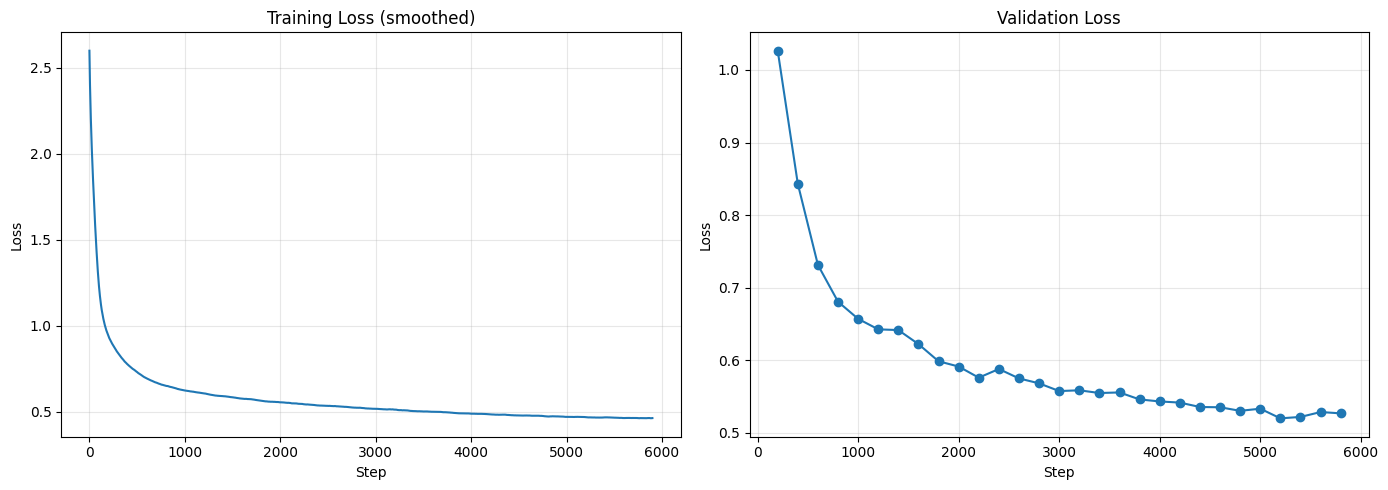

In [ ]:
# Plot training curves
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Training loss (smoothed)
window = 100
smoothed = np.convolve(train_losses, np.ones(window)/window, mode='valid')
ax1.plot(smoothed)
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss (smoothed)')
ax1.grid(True, alpha=0.3)

# Validation loss
if val_losses:
    steps, losses = zip(*val_losses)
    ax2.plot(steps, losses, 'o-')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Loss')
    ax2.set_title('Validation Loss')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/training_curves.png', dpi=150)
plt.show()

## 6. Test Generation

In [ ]:
# Generate sample text
model.eval()

prompts = [
    "The meaning of life is",
    "In a world where artificial intelligence",
    "Once upon a time, there was a",
    "The best way to learn programming is",
]

print("Sample generations:")
print("=" * 60)

for prompt in prompts:
    idx = torch.tensor([list(prompt.encode('utf-8'))], dtype=torch.long, device=DEVICE)
    output = model.generate(idx, max_new_tokens=150, temperature=0.8, top_k=40)
    text = bytes(output[0].tolist()).decode('utf-8', errors='replace')

    print(f"\nPrompt: {prompt}")
    print(f"Output: {text}")
    print("-" * 60)

Sample generations:

Prompt: The meaning of life is
Output: The meaning of life is a magical part of a raisy way. She has a special pink wagon that can take things that are allowed to touch.

Once upon a time there was a big party. 
------------------------------------------------------------

Prompt: In a world where artificial intelligence
Output: In a world where artificial intelligence and a whale wanted to be saved!

The fish and the whale worked together to build a river. Soon the whale was sailing around the river with soap! Ever
------------------------------------------------------------

Prompt: Once upon a time, there was a
Output: Once upon a time, there was a big man who had a special gun. He had a stick and he helped to pull things that were not toys. One day, the man asked a little girl to help him pull 
------------------------------------------------------------

Prompt: The best way to learn programming is
Output: The best way to learn programming is more important th

---

## 7. Sparse Autoencoder (SAE) Training

Now we train a sparse autoencoder on the residual stream to extract interpretable features.

In [ ]:
# Load model from Google Drive checkpoint
import torch

# Options: 'best', 'final', or a specific step number like 1000
CHECKPOINT_TYPE = 'best'

# Construct path based on checkpoint type
if CHECKPOINT_TYPE == 'best':
    checkpoint_path = f'{SAVE_DIR}/checkpoints/best_model.pt'
elif CHECKPOINT_TYPE == 'final':
    checkpoint_path = f'{SAVE_DIR}/char_gpt_final.pt'
else:
    checkpoint_path = f'{SAVE_DIR}/checkpoints/step_{CHECKPOINT_TYPE}.pt'

print(f"Loading checkpoint from: {checkpoint_path}")

# Load checkpoint - disable weights_only since we trust our own checkpoint
checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
# Reconstruct config
config = checkpoint['config']
print(f"\nModel config:")
print(f"  d_model: {config.d_model}")
print(f"  n_layers: {config.n_layers}")
print(f"  n_heads: {config.n_heads}")
print(f"  context_length: {config.context_length}")

# Create model and load weights
model = CharGPT(config).to(DEVICE)
model.load_state_dict(checkpoint['model'])
model.eval()

# Print checkpoint info
if 'step' in checkpoint:
    print(f"\nCheckpoint step: {checkpoint['step']}")
if 'loss' in checkpoint:
    print(f"Checkpoint loss: {checkpoint['loss']:.4f}")

n_params = sum(p.numel() for p in model.parameters())
print(f"Loaded model with {n_params / 1e6:.2f}M parameters")

Loading checkpoint from: /content/drive/MyDrive/char_gpt_sae/checkpoints/best_model.pt

Model config:
  d_model: 512
  n_layers: 8
  n_heads: 8
  context_length: 512

Checkpoint step: 5200
Checkpoint loss: 0.5201
Loaded model with 25.83M parameters


In [ ]:
from collections import defaultdict
import json

@dataclass
class SAEConfig:
    """Configuration for Sparse Autoencoder."""
    d_model: int = 512              # Input dimension
    n_features: int = 16384         # SAE features (32x expansion)
    k: int = 32                     # Top-k active features

    learning_rate: float = 1e-4
    batch_size: int = 4096
    warmup_steps: int = 1000
    total_steps: int = 30000

    tied_weights: bool = False
    normalize_decoder: bool = True

    aux_k: int = 256
    aux_loss_coef: float = 1/32

    dead_threshold: int = 10000
    resample_dead: bool = True


class TopKSparseAutoencoder(nn.Module):
    """Sparse Autoencoder with Top-K activation selection."""

    def __init__(self, config: SAEConfig):
        super().__init__()
        self.config = config

        self.encoder = nn.Linear(config.d_model, config.n_features, bias=True)
        self.decoder = nn.Linear(config.n_features, config.d_model, bias=False)
        self.pre_bias = nn.Parameter(torch.zeros(config.d_model))

        self._init_weights()

        self.register_buffer('feature_activation_counts',
                           torch.zeros(config.n_features, dtype=torch.long))
        self.register_buffer('total_steps', torch.tensor(0, dtype=torch.long))

    def _init_weights(self):
        nn.init.kaiming_uniform_(self.encoder.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.decoder.weight, a=math.sqrt(5))
        with torch.no_grad():
            # Normalize columns of the decoder weight matrix (features directions)
            self.decoder.weight.data = F.normalize(self.decoder.weight.data, dim=1)
        nn.init.zeros_(self.encoder.bias)
        nn.init.zeros_(self.pre_bias)

    def normalize_decoder_(self):
        with torch.no_grad():
            # Normalize columns of the decoder weight matrix (features directions)
            self.decoder.weight.data = F.normalize(self.decoder.weight.data, dim=1)

    def encode(self, x):
        x_centered = x - self.pre_bias
        z_pre = self.encoder(x_centered)
        z_relu = F.relu(z_pre)
        topk_values, topk_indices = torch.topk(z_relu, self.config.k, dim=-1)
        z_topk = torch.zeros_like(z_pre)
        z_topk.scatter_(dim=-1, index=topk_indices, src=topk_values)
        return z_topk, topk_indices, topk_values

    def decode(self, z):
        # z is [batch, n_features], decoder.weight is [d_model, n_features]
        # Need to transpose: [batch, n_features] @ [n_features, d_model] = [batch, d_model]
        return z @ self.decoder.weight.T + self.pre_bias

    def forward(self, x, return_aux=True):
        z, topk_indices, topk_values = self.encode(x)
        x_hat = self.decode(z)

        recon_loss = F.mse_loss(x_hat, x)

        if self.training:
            self.total_steps += 1
            unique_features = topk_indices.unique()
            self.feature_activation_counts[unique_features] = self.total_steps

        aux_loss = torch.tensor(0.0, device=x.device)
        if return_aux and self.config.aux_loss_coef > 0:
            residual = x - x_hat
            z_pre_residual = self.encoder(residual)
            z_relu_residual = F.relu(z_pre_residual)

            mask = torch.ones_like(z_relu_residual)
            mask.scatter_(dim=-1, index=topk_indices,
                        src=torch.zeros_like(topk_indices, dtype=mask.dtype))
            z_masked = z_relu_residual * mask

            aux_values, aux_indices = torch.topk(z_masked, self.config.aux_k, dim=-1)
            z_aux = torch.zeros_like(z_pre_residual)
            z_aux.scatter_(dim=-1, index=aux_indices, src=aux_values)

            residual_hat = self.decode(z_aux)
            aux_loss = F.mse_loss(residual_hat, residual)

        loss = recon_loss + self.config.aux_loss_coef * aux_loss

        return {
            'x_hat': x_hat, 'z': z,
            'topk_indices': topk_indices, 'topk_values': topk_values,
            'loss': loss, 'recon_loss': recon_loss, 'aux_loss': aux_loss,
        }

    def get_dead_features(self):
        steps_since = self.total_steps - self.feature_activation_counts
        return (steps_since > self.config.dead_threshold).nonzero().squeeze(-1)

    @torch.no_grad()
    def resample_dead_features(self, data_sample):
        dead_indices = self.get_dead_features()
        if len(dead_indices) == 0:
            return 0

        output = self.forward(data_sample, return_aux=False)
        losses = (output['x_hat'] - data_sample).pow(2).mean(dim=-1)
        probs = losses / losses.sum()
        sample_indices = torch.multinomial(probs, len(dead_indices), replacement=True)

        for i, dead_idx in enumerate(dead_indices):
            new_dir = data_sample[sample_indices[i]] - self.pre_bias
            new_dir = F.normalize(new_dir, dim=-1)
            self.encoder.weight.data[dead_idx] = new_dir * 0.2
            self.encoder.bias.data[dead_idx] = 0.0
            # Update the corresponding column in the decoder weight matrix
            self.decoder.weight.data[:, dead_idx] = new_dir

        self.feature_activation_counts[dead_indices] = self.total_steps
        return len(dead_indices)


print("SAE classes defined!")

## 8. Collect Activations from GPT

In [ ]:
# Configuration
LAYER_IDX = 4            # Middle layer often has good features
POSITION = 'mid'         # After attention, before MLP
MAX_ACTIVATIONS = 250000 # Number of activation vectors to collect

print(f"Collecting activations from layer {LAYER_IDX}, position '{POSITION}'")
print(f"Target: {MAX_ACTIVATIONS:,} vectors")

Target: 250,000 vectors


In [ ]:
# Create datasets and dataloaders
train_dataset = CharDataset(train_data, config.context_length)
val_dataset = CharDataset(val_data, config.context_length)

In [ ]:
# Collect activations - memory efficient version
model.eval()

# Pre-allocate tensor on CPU
activations = torch.empty(MAX_ACTIVATIONS, config.d_model, dtype=torch.float32)
total_collected = 0

activation_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0  # reduce to 0 to save RAM
)

pbar = tqdm(total=MAX_ACTIVATIONS, desc="Collecting activations")

with torch.no_grad():
    for x, _ in activation_loader:
        x = x.to(DEVICE)

        output = model(x, return_residuals=True, layers_to_capture=[LAYER_IDX])

        layer_key = f'layer_{LAYER_IDX}'
        if layer_key in output['residuals']:
            acts = output['residuals'][layer_key][POSITION]
            acts = acts.view(-1, acts.size(-1)).cpu()  # [B*T, d_model]

            # Calculate how many we can still add
            n_to_add = min(acts.size(0), MAX_ACTIVATIONS - total_collected)

            # Write directly into pre-allocated tensor
            activations[total_collected:total_collected + n_to_add] = acts[:n_to_add]
            total_collected += n_to_add
            pbar.update(n_to_add)

            if total_collected >= MAX_ACTIVATIONS:
                break

pbar.close()

# Trim if needed (shouldn't be necessary)
activations = activations[:total_collected]

print(f"\nCollected {len(activations):,} activation vectors")
print(f"Shape: {activations.shape}")
print(f"Memory: {activations.numel() * 4 / 1e9:.2f} GB")
print(f"Mean: {activations.mean():.4f}, Std: {activations.std():.4f}")


Collected 250,000 activation vectors
Shape: torch.Size([250000, 512])
Memory: 0.51 GB
Mean: -0.0177, Std: 3.0300


In [ ]:
# Save activations to Drive (optional, for resuming)
act_path = f'{SAVE_DIR}/activations_layer{LAYER_IDX}_{POSITION}.pt'
torch.save(activations, act_path)
print(f"Saved activations to {act_path}")

Saved activations to /content/drive/MyDrive/char_gpt_sae/activations_layer4_mid.pt


## 9. Train SAE

In [ ]:
# SAE Configuration
sae_config = SAEConfig(
    d_model=config.d_model,  # 512
    n_features=16384,        # 32x expansion
    k=32,                    # Top-k sparsity
    learning_rate=1e-4,
    batch_size=4096,
    total_steps=30000,
)

print(f"SAE Configuration:")
print(f"  Input dim: {sae_config.d_model}")
print(f"  Features: {sae_config.n_features}")
print(f"  Top-k: {sae_config.k}")
print(f"  Expansion: {sae_config.n_features / sae_config.d_model:.1f}x")

# Create SAE
sae = TopKSparseAutoencoder(sae_config).to(DEVICE)
n_sae_params = sum(p.numel() for p in sae.parameters())
print(f"  Parameters: {n_sae_params / 1e6:.2f}M")

SAE Configuration:
  Input dim: 512
  Features: 16384
  Top-k: 32
  Expansion: 32.0x
  Parameters: 16.79M


In [ ]:
# Training setup
sae_optimizer = torch.optim.Adam(sae.parameters(), lr=sae_config.learning_rate)

# Create activation dataset
class ActivationDataset(Dataset):
    def __init__(self, activations):
        self.activations = activations
    def __len__(self):
        return len(self.activations)
    def __getitem__(self, idx):
        return self.activations[idx]

act_dataset = ActivationDataset(activations)
act_loader = DataLoader(
    act_dataset,
    batch_size=sae_config.batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print(f"Activation batches: {len(act_loader)}")

Activation batches: 62


In [ ]:
# Patch the decode method
def fixed_decode(self, z):
    return z @ self.decoder.weight.T + self.pre_bias

# Apply fix
import types
sae.decode = types.MethodType(fixed_decode, sae)

print("Fixed SAE decode method")
print(f"z shape will be: [batch, {sae_config.n_features}]")
print(f"decoder.weight shape: {sae.decoder.weight.shape}")
print(f"output shape will be: [batch, {sae_config.d_model}]")

Fixed SAE decode method
z shape will be: [batch, 16384]
decoder.weight shape: torch.Size([512, 16384])
output shape will be: [batch, 512]


In [ ]:
temp_step = step

In [ ]:
# SAE Training loop
print("\nStarting SAE training...")
print("=" * 60)

sae.train()
act_iter = iter(act_loader)
sae_metrics = defaultdict(list)

for step in range(temp_step, sae_config.total_steps):
    # Learning rate warmup
    if step < sae_config.warmup_steps:
        lr = sae_config.learning_rate * (step + 1) / sae_config.warmup_steps
        for pg in sae_optimizer.param_groups:
            pg['lr'] = lr

    # Get batch
    try:
        batch = next(act_iter)
    except StopIteration:
        act_iter = iter(act_loader)
        batch = next(act_iter)

    batch = batch.to(DEVICE)

    # Forward
    output = sae(batch)
    loss = output['loss']

    # Backward
    sae_optimizer.zero_grad()
    loss.backward()
    sae_optimizer.step()

    # Normalize decoder
    sae.normalize_decoder_()

    # Logging
    if step % 500 == 0:
        with torch.no_grad():
            n_active = (output['z'] > 0).float().sum(dim=-1).mean().item()
            n_dead = len(sae.get_dead_features())
            utilization = 1 - n_dead / sae_config.n_features

            x_var = batch.var()
            residual_var = (batch - output['x_hat']).var()
            explained_var = (1 - residual_var / x_var).item()

        sae_metrics['step'].append(step)
        sae_metrics['recon_loss'].append(output['recon_loss'].item())
        sae_metrics['explained_var'].append(explained_var)
        sae_metrics['utilization'].append(utilization)

        print(f"step {step:5d} | recon {output['recon_loss'].item():.4f} | "
              f"aux {output['aux_loss'].item():.4f} | active {n_active:.1f} | "
              f"util {utilization:.1%} | expl_var {explained_var:.1%}")

    # Resample dead features
    if sae_config.resample_dead and step > 0 and step % 5000 == 0:
        sample_idx = torch.randperm(len(activations))[:10000]
        sample = activations[sample_idx].to(DEVICE)
        n_resampled = sae.resample_dead_features(sample)
        if n_resampled > 0:
            print(f"  → Resampled {n_resampled} dead features")

    # Save checkpoint
    if step > 0 and step % 10000 == 0:
        import dataclasses # Ensure dataclasses is imported
        sae_path = f'{SAVE_DIR}/sae_checkpoints/sae_step_{step}.pt'
        torch.save({
            'model': sae.state_dict(),
            'config': dataclasses.asdict(sae_config), # Save config as dict
            'optimizer': sae_optimizer.state_dict(),
            'step': step,
        }, sae_path)
        print(f"  → Saved SAE to {sae_path}")

print("\n" + "=" * 60)
print("SAE Training complete!")


Starting SAE training...
step     0 | recon 11.0336 | aux 21.8279 | active 32.0 | util 100.0% | expl_var -20.7%
step   500 | recon 6.0558 | aux 8.5559 | active 32.0 | util 100.0% | expl_var 34.2%
step  1000 | recon 2.5415 | aux 2.9205 | active 32.0 | util 100.0% | expl_var 72.4%
step  1500 | recon 1.7359 | aux 1.6465 | active 32.0 | util 100.0% | expl_var 81.2%
step  2000 | recon 1.4215 | aux 1.1937 | active 32.0 | util 100.0% | expl_var 84.5%
step  2500 | recon 1.2594 | aux 0.9752 | active 32.0 | util 100.0% | expl_var 86.1%
step  3000 | recon 1.1651 | aux 0.8464 | active 32.0 | util 100.0% | expl_var 87.3%
step  3500 | recon 1.0741 | aux 0.7375 | active 32.0 | util 100.0% | expl_var 88.2%
step  4000 | recon 1.0097 | aux 0.6643 | active 32.0 | util 100.0% | expl_var 89.0%
step  4500 | recon 0.9549 | aux 0.6046 | active 32.0 | util 100.0% | expl_var 89.6%
step  5000 | recon 0.9241 | aux 0.5630 | active 32.0 | util 100.0% | expl_var 90.0%
step  5500 | recon 0.8702 | aux 0.5138 | active

PicklingError: Can't pickle <class '__main__.SAEConfig'>: it's not the same object as __main__.SAEConfig

In [ ]:
 # Save checkpoint

import dataclasses # Ensure dataclasses is imported
sae_path = f'{SAVE_DIR}/sae_checkpoints/sae_step_{step}.pt'
torch.save({
    'model': sae.state_dict(),
    'config': dataclasses.asdict(sae_config), # Save config as dict
    'step': step,
}, sae_path)
print(f"  → Saved SAE to {sae_path}")

  → Saved SAE to /content/drive/MyDrive/char_gpt_sae/sae_checkpoints/sae_step_10000.pt


In [ ]:
# Resume SAE training from checkpoint
import torch
import dataclasses # Import dataclasses

# Find the latest SAE checkpoint
sae_ckpt_dir = f'{SAVE_DIR}/sae_checkpoints'
sae_checkpoints = [f for f in os.listdir(sae_ckpt_dir) if f.startswith('sae_step_')]

if not sae_checkpoints:
    raise FileNotFoundError("No SAE checkpoints found!")

# Get the latest one
latest_step = max(int(f.split('_')[-1].replace('.pt', '')) for f in sae_checkpoints)
sae_ckpt_path = f'{sae_ckpt_dir}/sae_step_{latest_step}.pt'

print(f"Resuming from: {sae_ckpt_path}")

# Load checkpoint
sae_ckpt = torch.load(sae_ckpt_path, map_location=DEVICE, weights_only=False)

# Recreate SAE and load weights
sae_config_dict = sae_ckpt['config'] # Load as dict
# Reconstruct SAEConfig object from the dictionary
sae_config = SAEConfig(**sae_config_dict)
sae = TopKSparseAutoencoder(sae_config).to(DEVICE)
sae.load_state_dict(sae_ckpt['model'])

# Apply the decode fix again
import types
def fixed_decode(self, z):
    return z @ self.decoder.weight.T + self.pre_bias
sae.decode = types.MethodType(fixed_decode, sae)

# Recreate optimizer
sae_optimizer = torch.optim.Adam(sae.parameters(), lr=sae_config.learning_rate)

start_step = sae_ckpt['step']
print(f"Resuming from step {start_step}")
print(f"Will train until step {sae_config.total_steps}")

Resuming from: /content/drive/MyDrive/char_gpt_sae/sae_checkpoints/sae_step_10000.pt
Resuming from step 10000
Will train until step 30000


In [ ]:
# Resume SAE training loop
print(f"\nResuming SAE training from step {start_step}...")
print("=" * 60)

sae.train()
act_iter = iter(act_loader)
sae_metrics = defaultdict(list)

for step in range(start_step + 1, sae_config.total_steps):
    # Learning rate (no warmup since we're past it)
    lr = sae_config.learning_rate
    for pg in sae_optimizer.param_groups:
        pg['lr'] = lr

    # Get batch
    try:
        batch = next(act_iter)
    except StopIteration:
        act_iter = iter(act_loader)
        batch = next(act_iter)

    batch = batch.to(DEVICE)

    # Forward
    output = sae(batch)
    loss = output['loss']

    # Backward
    sae_optimizer.zero_grad()
    loss.backward()
    sae_optimizer.step()

    # Normalize decoder
    sae.normalize_decoder_()

    # Logging
    if step % 500 == 0:
        with torch.no_grad():
            n_active = (output['z'] > 0).float().sum(dim=-1).mean().item()
            n_dead = len(sae.get_dead_features())
            utilization = 1 - n_dead / sae_config.n_features

            x_var = batch.var()
            residual_var = (batch - output['x_hat']).var()
            explained_var = (1 - residual_var / x_var).item()

        sae_metrics['step'].append(step)
        sae_metrics['recon_loss'].append(output['recon_loss'].item())
        sae_metrics['explained_var'].append(explained_var)
        sae_metrics['utilization'].append(utilization)

        print(f"step {step:5d} | recon {output['recon_loss'].item():.4f} | "
              f"aux {output['aux_loss'].item():.4f} | active {n_active:.1f} | "
              f"util {utilization:.1%} | expl_var {explained_var:.1%}")

    # Resample dead features
    if sae_config.resample_dead and step > 0 and step % 5000 == 0:
        sample_idx = torch.randperm(len(activations))[:10000]
        sample = activations[sample_idx].to(DEVICE)
        n_resampled = sae.resample_dead_features(sample)
        if n_resampled > 0:
            print(f"  → Resampled {n_resampled} dead features")

    # Save checkpoint (more frequently to be safe)
    # Save checkpoint
    if step > 0 and step % 10000 == 0:
        import dataclasses # Ensure dataclasses is imported
        sae_path = f'{SAVE_DIR}/sae_checkpoints/sae_step_{step}.pt'
        torch.save({
            'model': sae.state_dict(),
            'config': dataclasses.asdict(sae_config), # Save config as dict
            'step': step,
        }, sae_path)
        print(f"  → Saved SAE to {sae_path}")

print("\n" + "=" * 60)
print("SAE Training complete!")

# Save final
sae_final_path = f'{SAVE_DIR}/sae_final.pt'
torch.save({
    'model': sae.state_dict(),
    'config': sae_config,
    'metrics': dict(sae_metrics),
    'layer_idx': LAYER_IDX,
    'optimizer': sae_optimizer.state_dict(),
    'position': POSITION,
}, sae_final_path)
print(f"Saved final SAE to {sae_final_path}")


Resuming SAE training from step 10000...
step 10500 | recon 1.5819 | aux 0.7519 | active 32.0 | util 100.0% | expl_var 83.0%
step 11000 | recon 1.2796 | aux 0.6214 | active 32.0 | util 100.0% | expl_var 86.1%
step 11500 | recon 1.1465 | aux 0.5630 | active 32.0 | util 99.9% | expl_var 87.4%
step 12000 | recon 1.0748 | aux 0.5375 | active 32.0 | util 99.9% | expl_var 88.3%
step 12500 | recon 1.0188 | aux 0.5190 | active 32.0 | util 99.7% | expl_var 88.9%
step 13000 | recon 0.9841 | aux 0.5070 | active 32.0 | util 99.1% | expl_var 89.2%
step 13500 | recon 0.9563 | aux 0.5027 | active 32.0 | util 98.4% | expl_var 89.6%
step 14000 | recon 0.9156 | aux 0.4892 | active 32.0 | util 97.5% | expl_var 90.1%
step 14500 | recon 0.8944 | aux 0.4888 | active 32.0 | util 96.7% | expl_var 90.3%
step 15000 | recon 0.8650 | aux 0.4776 | active 32.0 | util 96.1% | expl_var 90.6%
  → Resampled 641 dead features
step 15500 | recon 0.8800 | aux 0.4706 | active 32.0 | util 99.7% | expl_var 90.4%
step 16000 

In [ ]:

# Save final SAE
sae_final_path = f'{SAVE_DIR}/sae_final.pt'
torch.save({
    'model': sae.state_dict(),
    'config': sae_config,
    'metrics': dict(sae_metrics),
    'layer_idx': LAYER_IDX,
    'position': POSITION,
    'optimizer': sae_optimizer.state_dict(),
}, sae_final_path)
print(f"Saved final SAE to {sae_final_path}")

Saved final SAE to /content/drive/MyDrive/char_gpt_sae/sae_final.pt


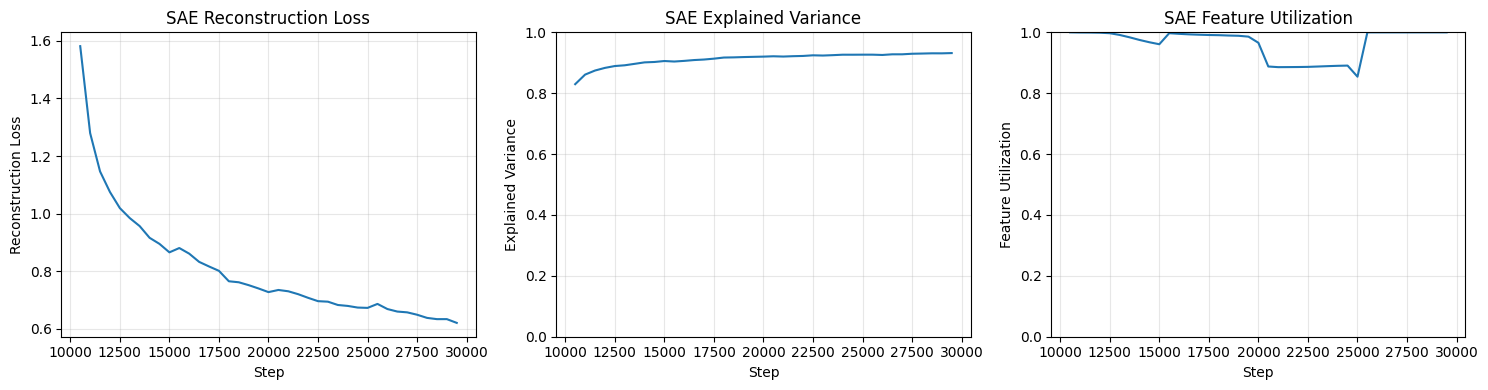

In [ ]:
import matplotlib.pyplot as plt
# Plot SAE training
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(sae_metrics['step'], sae_metrics['recon_loss'])
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Reconstruction Loss')
axes[0].set_title('SAE Reconstruction Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(sae_metrics['step'], sae_metrics['explained_var'])
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Explained Variance')
axes[1].set_title('SAE Explained Variance')
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3)

axes[2].plot(sae_metrics['step'], sae_metrics['utilization'])
axes[2].set_xlabel('Step')
axes[2].set_ylabel('Feature Utilization')
axes[2].set_title('SAE Feature Utilization')
axes[2].set_ylim(0, 1)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/sae_training_curves.png', dpi=150)
plt.show()

## 10. Feature Analysis

In [ ]:
# Analyze feature activation patterns
sae.eval()

# Compute activation statistics
feature_counts = torch.zeros(sae_config.n_features)
feature_sums = torch.zeros(sae_config.n_features)
feature_max = torch.zeros(sae_config.n_features)
n_samples = 0

with torch.no_grad():
    for i in range(0, len(activations), 4096):
        batch = activations[i:i+4096].to(DEVICE)
        output = sae(batch, return_aux=False)
        z = output['z'].cpu()

        feature_counts += (z > 0).float().sum(dim=0)
        feature_sums += z.sum(dim=0)
        feature_max = torch.maximum(feature_max, z.max(dim=0).values)
        n_samples += len(batch)

activation_freq = feature_counts / n_samples
mean_activation = feature_sums / feature_counts.clamp(min=1)

print(f"Feature Statistics:")
print(f"  Total features: {sae_config.n_features}")
print(f"  Dead features (never activated): {(feature_counts == 0).sum().item()}")
print(f"  Rare features (<0.1%): {(activation_freq < 0.001).sum().item()}")
print(f"  Mean activation frequency: {activation_freq.mean():.4f}")
print(f"  Median activation frequency: {activation_freq.median():.4f}")

Feature Statistics:
  Total features: 16384
  Dead features (never activated): 2844
  Rare features (<0.1%): 10311
  Mean activation frequency: 0.0020
  Median activation frequency: 0.0007


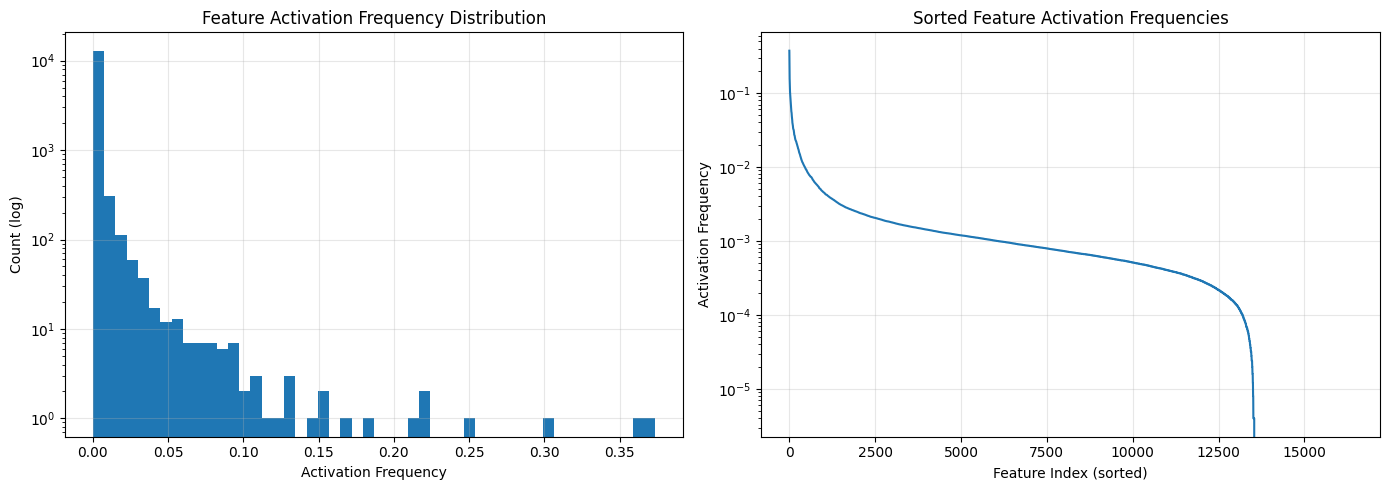

In [ ]:
# Plot activation frequency distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Log histogram of activation frequencies
freq_nonzero = activation_freq[activation_freq > 0]
axes[0].hist(freq_nonzero.numpy(), bins=50, log=True)
axes[0].set_xlabel('Activation Frequency')
axes[0].set_ylabel('Count (log)')
axes[0].set_title('Feature Activation Frequency Distribution')
axes[0].grid(True, alpha=0.3)

# Sorted activation frequencies
sorted_freq = activation_freq.sort(descending=True).values
axes[1].plot(sorted_freq.numpy())
axes[1].set_xlabel('Feature Index (sorted)')
axes[1].set_ylabel('Activation Frequency')
axes[1].set_title('Sorted Feature Activation Frequencies')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/feature_analysis.png', dpi=150)
plt.show()

In [ ]:
# Find most common features and what they activate on
print("\nTop 10 Most Frequent Features:")
print("=" * 60)

top_features = activation_freq.argsort(descending=True)[:10]

for rank, feat_idx in enumerate(top_features):
    freq = activation_freq[feat_idx].item()
    max_act = feature_max[feat_idx].item()
    print(f"  {rank+1}. Feature {feat_idx.item()}: freq={freq:.4f}, max={max_act:.2f}")


Top 10 Most Frequent Features:
  1. Feature 10503: freq=0.3737, max=697.86
  2. Feature 15275: freq=0.3594, max=255.81
  3. Feature 11508: freq=0.3026, max=250.28
  4. Feature 4102: freq=0.2506, max=562.77
  5. Feature 9512: freq=0.2223, max=516.23
  6. Feature 1764: freq=0.2169, max=249.57
  7. Feature 12676: freq=0.2103, max=241.37
  8. Feature 9885: freq=0.1801, max=208.10
  9. Feature 3818: freq=0.1668, max=327.46
  10. Feature 7046: freq=0.1536, max=202.25


## 11. Summary

Your trained models are saved to Google Drive at:

In [ ]:
print(f"📁 Save Directory: {SAVE_DIR}")
print(f"")
print(f"GPT Model:")
print(f"  • Final: {SAVE_DIR}/char_gpt_final.pt")
print(f"  • Best: {SAVE_DIR}/checkpoints/best_model.pt")
print(f"")
print(f"SAE Model:")
print(f"  • Final: {SAVE_DIR}/sae_final.pt")
print(f"  • Layer {LAYER_IDX}, position '{POSITION}'")
print(f"")
print(f"Data:")
print(f"  • Processed text: {SAVE_DIR}/openwebtext_500m.bin")
print(f"  • Activations: {SAVE_DIR}/activations_layer{LAYER_IDX}_{POSITION}.pt")
print(f"")
print(f"Plots:")
print(f"  • {SAVE_DIR}/training_curves.png")
print(f"  • {SAVE_DIR}/sae_training_curves.png")
print(f"  • {SAVE_DIR}/feature_analysis.png")

📁 Save Directory: /content/drive/MyDrive/char_gpt_sae

GPT Model:
  • Final: /content/drive/MyDrive/char_gpt_sae/char_gpt_final.pt
  • Best: /content/drive/MyDrive/char_gpt_sae/checkpoints/best_model.pt

SAE Model:
  • Final: /content/drive/MyDrive/char_gpt_sae/sae_final.pt
  • Layer 4, position 'mid'

Data:
  • Processed text: /content/drive/MyDrive/char_gpt_sae/openwebtext_500m.bin
  • Activations: /content/drive/MyDrive/char_gpt_sae/activations_layer4_mid.pt

Plots:
  • /content/drive/MyDrive/char_gpt_sae/training_curves.png
  • /content/drive/MyDrive/char_gpt_sae/sae_training_curves.png
  • /content/drive/MyDrive/char_gpt_sae/feature_analysis.png


In [ ]:
# List all saved files
!find {SAVE_DIR} -type f -name "*.pt" -o -name "*.png" -o -name "*.bin" | head -20

/content/drive/MyDrive/char_gpt_sae/checkpoints/best_model.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_500.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_1000.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_1500.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_2000.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_2500.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_3000.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_3500.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_4000.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_4500.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_5000.pt
/content/drive/MyDrive/char_gpt_sae/checkpoints/step_5500.pt
/content/drive/MyDrive/char_gpt_sae/sae_checkpoints/sae_step_10000.pt
/content/drive/MyDrive/char_gpt_sae/sae_checkpoints/sae_step_20000.pt
/content/drive/MyDrive/char_gpt_sae/TinyStories.bin
/content/drive/MyDrive/char_gpt_sae/char_gpt_final.pt
/content/drive/MyDrive

# Analysis

In [ ]:
# --- Configuration ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SAVE_DIR = '/content/drive/MyDrive/char_gpt_sae'
gpt_path = f'{SAVE_DIR}/checkpoints/best_model.pt'
sae_path = f'{SAVE_DIR}/sae_final.pt'

print(f"Loading from {SAVE_DIR} on {DEVICE}...")

# 1. Load GPT Model (Best Checkpoint)
if os.path.exists(gpt_path):
    print(f"Loading GPT (BEST) from {gpt_path}...")
    # weights_only=False is required because the checkpoint contains the custom Config object
    checkpoint = torch.load(gpt_path, map_location=DEVICE, weights_only=False)

    # Reconstruct Config
    if isinstance(checkpoint['config'], dict):
        gpt_config = GPTConfig(**checkpoint['config'])
    else:
        gpt_config = checkpoint['config']

    # Instantiate and Load
    # Ensure CharGPT class is defined (run the model definition cell first if needed)
    model = CharGPT(gpt_config)
    model.load_state_dict(checkpoint['model'])
    model.to(DEVICE)
    model.eval()
    print("GPT Model (Best) loaded successfully!")
else:
    print(f"WARNING: GPT model not found at {gpt_path}")

# 2. Load SAE Model
if os.path.exists(sae_path):
    print(f"Loading SAE from {sae_path}...")

    # !!! FIX: Added weights_only=False here !!!
    sae_checkpoint = torch.load(sae_path, map_location=DEVICE, weights_only=False)

    raw_sae_config = sae_checkpoint['config']
    if isinstance(raw_sae_config, dict):
        sae_config = SAEConfig(**raw_sae_config)
    else:
        sae_config = raw_sae_config

    sae = TopKSparseAutoencoder(sae_config)
    sae.load_state_dict(sae_checkpoint['model'])
    sae.to(DEVICE)
    sae.eval()
    print("SAE Model loaded successfully!")
else:
    print(f"WARNING: SAE model not found at {sae_path}")

Loading from /content/drive/MyDrive/char_gpt_sae on cuda...
Loading GPT (BEST) from /content/drive/MyDrive/char_gpt_sae/checkpoints/best_model.pt...
GPT Model (Best) loaded successfully!
Loading SAE from /content/drive/MyDrive/char_gpt_sae/sae_final.pt...
SAE Model loaded successfully!


Identifying common words...
Top words to test: ['the', 'and', 'was', 'to', 'a', 'he', 'it', 'she', 'they', 'his']

Scanning 500 batches for word occurrences...

Results: Top SAE Features per Word
------------------------------------------------------------
Word 'the       ': Feat 1094 (freq=77341, avg=140.13), Feat 1882 (freq=77341, avg=116.48), Feat 6367 (freq=77341, avg=116.69)
Word 'and       ': Feat 3885 (freq=76520, avg=107.35), Feat 2224 (freq=72757, avg=136.95), Feat 10855 (freq=51224, avg=43.95)
Word 'was       ': Feat 11763 (freq=44967, avg=80.11), Feat 2732 (freq=44907, avg=87.28), Feat 3512 (freq=44416, avg=115.70)
Word 'to        ': Feat 8327 (freq=53163, avg=89.50), Feat 13571 (freq=53163, avg=87.20), Feat 14996 (freq=53163, avg=66.74)
Word 'a         ': Feat 4878 (freq=39205, avg=99.34), Feat 15454 (freq=39205, avg=92.26), Feat 15165 (freq=39203, avg=128.81)
Word 'he        ': Feat 12282 (freq=36055, avg=146.78), Feat 14080 (freq=36039, avg=134.81), Feat 4938 (freq=35797,

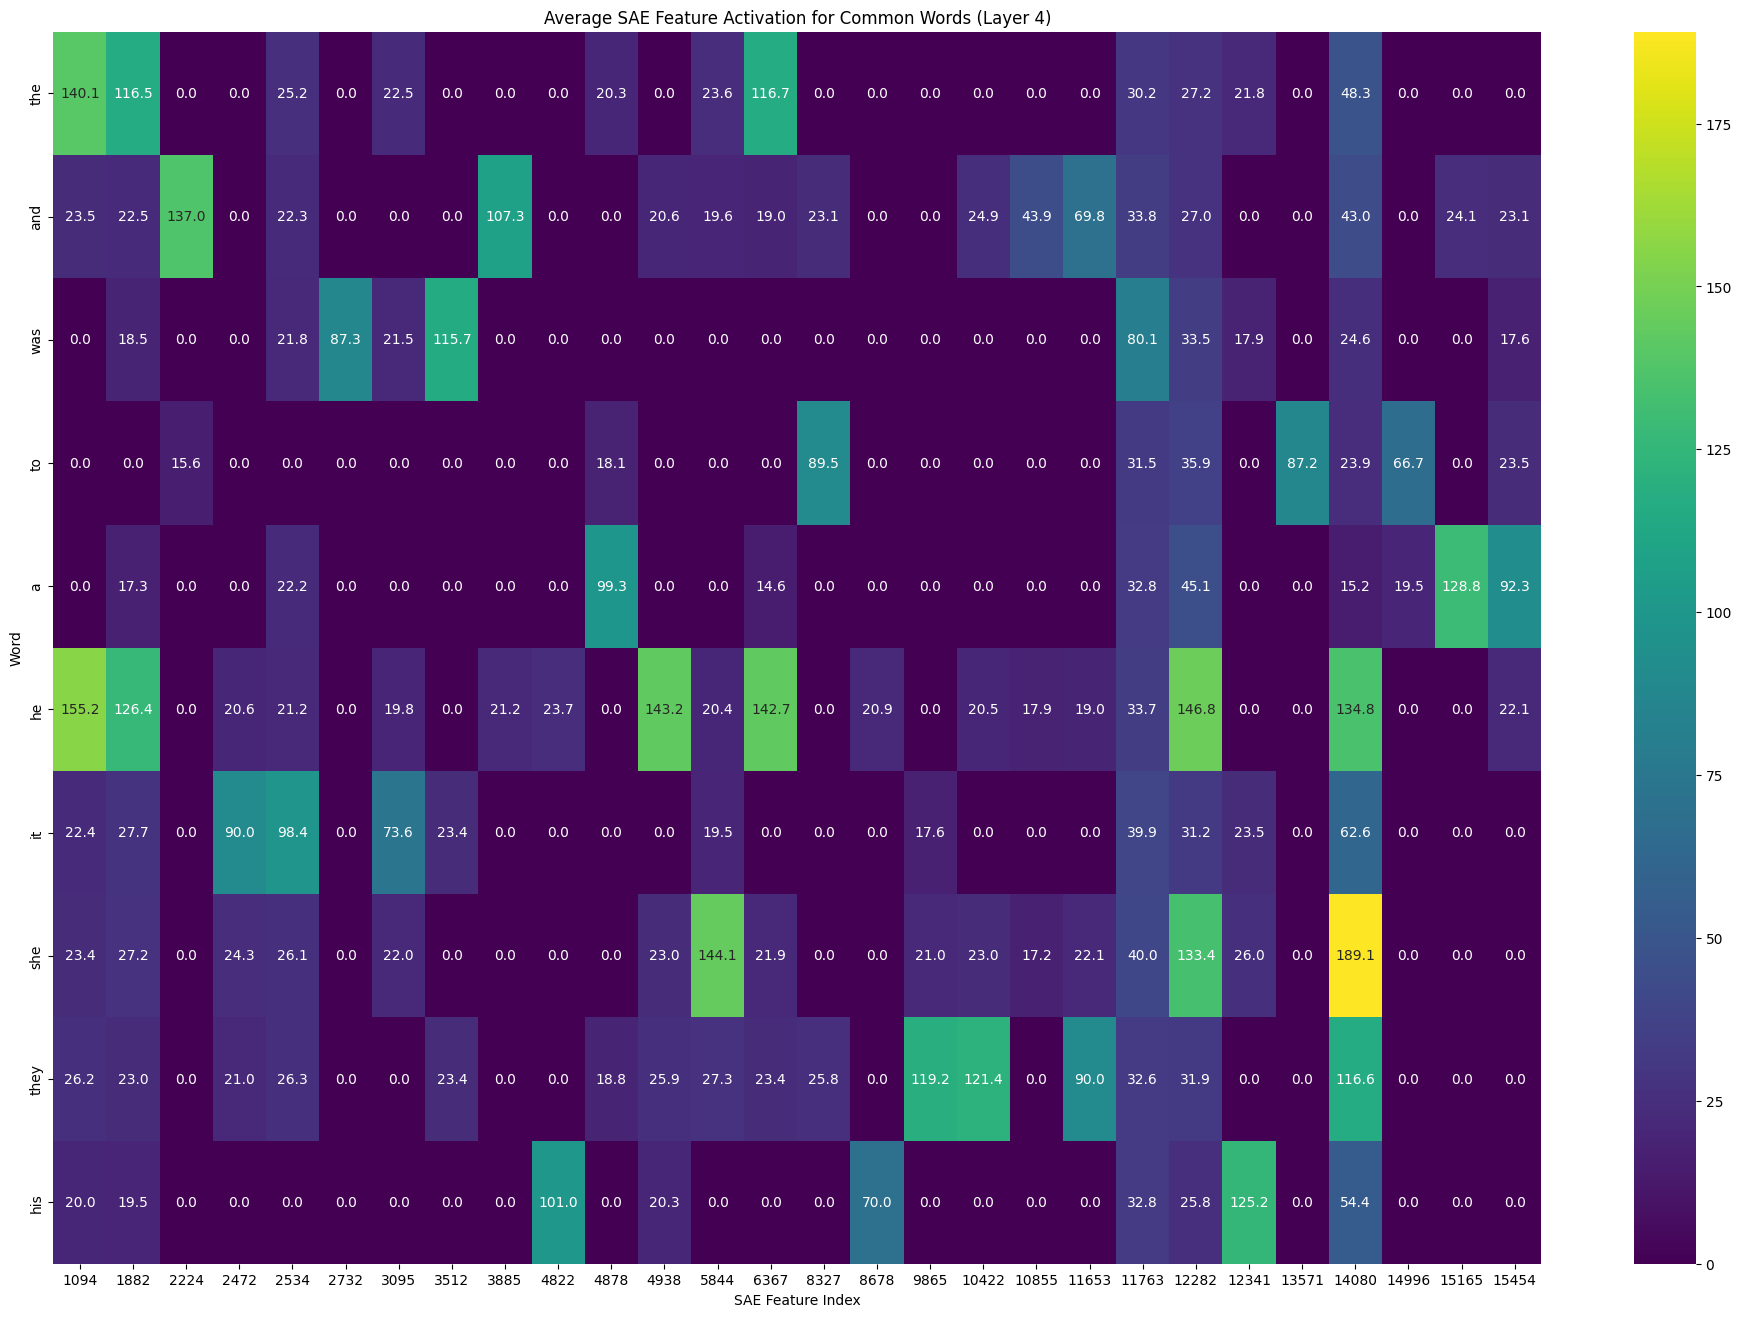

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict, Counter
import re

# --- Configuration ---
# Words to test (automatically finds top words, or you can set a custom list)
NUM_TOP_WORDS = 10
NUM_BATCHES_TO_SCAN = 500  # How much data to scan
LAYER_TO_PROBE = 4        # Must match the layer you trained the SAE on
POSITION_TO_PROBE = 'mid' # Must match SAE training ('mid' or 'post_mlp')

# 1. Identify Common Words in Validation Data
# ------------------------------------------
print("Identifying common words...")
decoder = {i: chr(i) for i in range(256)}
def decode_tokens(tokens):
    return "".join([decoder[t.item()] for t in tokens])

# Scan a bit of data to find frequencies
sample_text = val_data[:100000].decode('utf-8', errors='replace')
# Simple split by whitespace to count words
words = re.findall(r'\b\w+\b', sample_text.lower())
common_words = [w for w, c in Counter(words).most_common(NUM_TOP_WORDS)]
print(f"Top words to test: {common_words}")

# 2. Collect SAE Activations for these words
# ------------------------------------------
print(f"\nScanning {NUM_BATCHES_TO_SCAN} batches for word occurrences...")
word_feature_acts = defaultdict(list)

model.eval()
sae.eval()

with torch.no_grad():
    for batch_idx, (x, y) in enumerate(val_loader):
        if batch_idx >= NUM_BATCHES_TO_SCAN:
            break

        x = x.to(DEVICE)

        # Run GPT to get activations
        gpt_out = model(x, return_residuals=True, layers_to_capture=[LAYER_TO_PROBE])
        # [Batch, Seq_Len, D_Model]
        acts = gpt_out['residuals'][f'layer_{LAYER_TO_PROBE}'][POSITION_TO_PROBE]

        # Analyze text in this batch
        for b in range(x.shape[0]):
            text = decode_tokens(x[b])

            for word in common_words:
                # Find the word padded by spaces to ensure whole-word matching
                # (We search for " word " or " word." etc)
                # For simplicity in this script, we look for the literal sequence
                # and take the index of the last character of the word.

                # Regex to find word boundaries
                matches = list(re.finditer(rf'\b{re.escape(word)}\b', text, re.IGNORECASE))

                for m in matches:
                    end_idx = m.end() - 1 # Index of the last character

                    if end_idx < config.context_length:
                        # Grab the vector at the end of the word
                        # acts is [Batch, Seq, Dim]
                        vector = acts[b, end_idx, :] # [Dim]

                        # Pass through SAE
                        # encode returns: z, topk_indices, topk_values
                        _, topk_ind, topk_val = sae.encode(vector)

                        # Store the active features for this word instance
                        # We store pairs of (feature_index, activation_value)
                        for feat_idx, feat_val in zip(topk_ind.tolist(), topk_val.tolist()):
                            if feat_val > 0:
                                word_feature_acts[word].append((feat_idx, feat_val))

# 3. Aggregate and Visualize
# ------------------------------------------
print("\nResults: Top SAE Features per Word")
print("-" * 60)

unique_features_found = set()

# Prepare data for plotting
plot_data = []

for word in common_words:
    if word not in word_feature_acts:
        print(f"Word '{word}': No occurrences found in scan.")
        continue

    # Aggregate feature activations
    feature_counts = Counter()
    feature_sums = defaultdict(float)

    occurrences = len([x for x in word_feature_acts[word]]) # Rough proxy for total hits

    for fid, val in word_feature_acts[word]:
        feature_counts[fid] += 1
        feature_sums[fid] += val

    # Get top 3 features by frequency of firing
    top_features = feature_counts.most_common(3)

    feats_str = []
    for fid, count in top_features:
        avg_act = feature_sums[fid] / count
        feats_str.append(f"Feat {fid} (freq={count}, avg={avg_act:.2f})")
        unique_features_found.add(fid)
        plot_data.append({'Word': word, 'Feature': str(fid), 'Score': avg_act * count}) # Score = Total Activation Mass

    print(f"Word '{word:<10}': {', '.join(feats_str)}")

# 4. Heatmap Visualization
# ------------------------------------------
if plot_data:
    # Create a matrix: Words x Top Unique Features
    # We collect all unique features that appeared in top-3 lists
    top_feats_list = sorted(list(unique_features_found))
    matrix = np.zeros((len(common_words), len(top_feats_list)))

    for i, word in enumerate(common_words):
        if word not in word_feature_acts: continue

        # Re-calculate average activation for these specific top features
        # to fill the matrix (even if it wasn't the #1 feature for this word)
        current_word_data = word_feature_acts[word] # list of (fid, val)
        feat_map = defaultdict(float)
        count_map = defaultdict(int)
        for fid, val in current_word_data:
            feat_map[fid] += val
            count_map[fid] += 1

        for j, fid in enumerate(top_feats_list):
            if count_map[fid] > 0:
                # Metric: Average activation magnitude
                matrix[i, j] = feat_map[fid] / count_map[fid]

    plt.figure(figsize=(24, 16))
    sns.heatmap(matrix, xticklabels=top_feats_list, yticklabels=common_words, cmap="viridis", annot=True, fmt=".1f")
    plt.title(f"Average SAE Feature Activation for Common Words (Layer {LAYER_TO_PROBE})")
    plt.xlabel("SAE Feature Index")
    plt.ylabel("Word")
    plt.show()

In [ ]:
import torch
import re
from collections import defaultdict, Counter
import pandas as pd

# --- Configuration ---
NUM_WORDS_TO_TEST = 50       # Look at top 50 words
ACTIVATION_THRESHOLD = 1.0   # Only count features with activation > this value
MIN_FIRING_RATE = 0.4        # Feature must fire in at least 40% of the word's occurrences to be listed
NUM_BATCHES = 100            # Scan more data for better statistics

# 1. Identify Words
# -----------------
print(f"identifying top {NUM_WORDS_TO_TEST} words...")
# Helper to decode for finding words
decoder = {i: chr(i) for i in range(256)}
def decode_str(tokens):
    return "".join([decoder[t.item()] for t in tokens])

# Get a sample text to find common words
sample_text = val_data[:200000].decode('utf-8', errors='replace')
words_found = re.findall(r'\b[a-zA-Z]+\b', sample_text.lower()) # simple alpha words
target_words = [w for w, c in Counter(words_found).most_common(NUM_WORDS_TO_TEST)]

print(f"Target words: {target_words}")

# 2. Collect Stats
# ----------------
# Structure: word_stats[word][feature_index] = list of activation values
word_stats = defaultdict(lambda: defaultdict(list))
word_counts = Counter()

# --- Configuration ---
MIN_OCCURRENCES = 30       # Target: Find at least 30 examples of each word
MAX_BATCHES = 500          # Safety limit: Don't scan forever if a word is super rare
# ---------------------

print(f"\nScanning until we find {MIN_OCCURRENCES} examples per word (or limit {MAX_BATCHES} batches)...")

model.eval()
sae.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(val_loader):
        # Stop if we have enough data for ALL words OR we hit the limit
        all_satisfied = all(word_counts[w] >= MIN_OCCURRENCES for w in target_words)
        if all_satisfied:
            print(f"Stopping early at batch {batch_idx}: collected enough samples for all words.")
            break
        if batch_idx >= MAX_BATCHES:
            print(f"Stopping at max limit {batch_idx} batches.")
            break

        x = x.to(DEVICE)

        # ... (Rest of the activation harvesting code is the same) ...
        # Get Model Activations
        out = model(x, return_residuals=True, layers_to_capture=[4])
        acts = out['residuals']['layer_4']['mid']

        for b in range(x.shape[0]):
            text = decode_str(x[b])
            for word in target_words:
                # OPTIMIZATION: Skip processing this word if we already have enough samples
                if word_counts[word] >= MIN_OCCURRENCES:
                    continue

                for m in re.finditer(rf'\b{re.escape(word)}\b', text, re.IGNORECASE):
                    end_idx = m.end() - 1
                    if end_idx < config.context_length:
                        # ... (encode and record stats) ...
                        vector = acts[b, end_idx, :]
                        _, topk_ind, topk_val = sae.encode(vector)

                        word_counts[word] += 1

                        inds = topk_ind.cpu().numpy()
                        vals = topk_val.cpu().numpy()
                        for idx, val in zip(inds, vals):
                            if val > ACTIVATION_THRESHOLD:
                                word_stats[word][idx].append(val)
# 3. Process and Display Results
# ------------------------------
print(f"\n{'='*80}")
print(f"{'WORD':<15} | {'COUNT':<5} | {'SIGNIFICANT FEATURES (> threshold & consistent)'}")
print(f"{'='*80}")

# Store for reverse lookup (Feature -> Words)
feature_to_words = defaultdict(list)

for word in target_words:
    count = word_counts[word]
    if count == 0: continue

    significant_features = []

    # Analyze features for this word
    for fid, values in word_stats[word].items():
        firing_count = len(values)
        firing_rate = firing_count / count
        avg_act = sum(values) / firing_count

        if firing_rate >= MIN_FIRING_RATE:
            feat_desc = f"F{fid}({firing_rate:.0%}, {avg_act:.1f})"
            significant_features.append((fid, firing_rate, feat_desc))

            # Save for reverse lookup
            feature_to_words[fid].append((word, firing_rate))

    # Sort by firing rate (consistency)
    significant_features.sort(key=lambda x: x[1], reverse=True)

    # Format output
    feats_str = ", ".join([x[2] for x in significant_features[:10]]) # Show top n
    if len(significant_features) > 5:
        feats_str += ", ..."

    print(f"{word:<15} | {count:<5} | {feats_str}")

# 4. (Optional) Reverse Lookup: What do specific features mean?
# -------------------------------------------------------------
print(f"\n{'='*80}")
print("REVERSE LOOKUP: Features shared by multiple words")
print(f"{'='*80}")

sorted_features = sorted(feature_to_words.items(), key=lambda x: len(x[1]), reverse=True)

for fid, word_list in sorted_features[:10]: # Top 10 most common features
    if len(word_list) > 1:
        words_str = ", ".join([f"{w}({rate:.0%})" for w, rate in word_list])
        print(f"Feature {fid:<6} : {words_str}")

identifying top 50 words...
Target words: ['the', 'and', 'to', 'was', 'a', 'he', 'it', 'she', 'her', 'they', 'so', 'his', 'in', 'day', 'of', 'said', 'that', 'had', 'little', 'but', 'with', 'there', 'one', 'time', 's', 'very', 'once', 'for', 'girl', 'on', 'you', 'big', 'mom', 'happy', 'were', 'upon', 'saw', 'all', 't', 'i', 'wanted', 'tim', 'went', 'at', 'him', 'as', 'friends', 'around', 'when', 'back']

Scanning until we find 30 examples per word (or limit 500 batches)...
Stopping at max limit 500 batches.

WORD            | COUNT | SIGNIFICANT FEATURES (> threshold & consistent)
the             | 32    | F1094(100%, 148.8), F1882(100%, 131.2), F6367(100%, 106.0), F5033(100%, 84.9), F14927(100%, 85.9), F2006(100%, 85.1), F202(100%, 84.6), F3876(100%, 78.2), F9722(100%, 68.1), F2163(88%, 66.1), ...
and             | 30    | F2224(100%, 148.9), F3885(100%, 117.6), F10855(100%, 76.0), F2205(100%, 47.0), F12992(100%, 46.0), F6090(100%, 44.7), F11508(100%, 57.4), F10747(100%, 32.8), F11763(

In [ ]:
import torch
import torch.nn.functional as F

# --- Configuration ---
# 1. Enter the Feature IDs you found interesting from the previous step
# (Example: The features you found for 'the')
INTERESTING_FEATURES = [1094, 1882, 6367, 5033]

# 2. Settings
NUM_BATCHES_DEEP_DIVE = 50
EXAMPLE_CONTEXT_SIZE = 20  # Show 20 chars around the activation

# Storage
feature_data = {fid: {'activations': [], 'contexts': []} for fid in INTERESTING_FEATURES}

print(f"Deep diving into features: {INTERESTING_FEATURES}...")

# 1. Collect Data (Max Activating Examples)
# -----------------------------------------
model.eval()
sae.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(val_loader):
        if batch_idx >= NUM_BATCHES_DEEP_DIVE:
            break

        x = x.to(DEVICE)

        # Get activations
        out = model(x, return_residuals=True, layers_to_capture=[4])
        acts = out['residuals']['layer_4']['mid'] # [Batch, Seq, Dim]

        # We need to flatten to run SAE efficiently or loop
        # Let's loop for clarity and context extraction
        for b in range(x.shape[0]):
            # Get the SAE feature activations for this entire sequence
            # Vector: [Seq, Dim] -> SAE -> [Seq, Num_Features] (sparse)
            # Optimization: Only compute if we strictly need to, but explicit loop is safer for context

            # For speed, let's run the whole sequence through the SAE encoder
            # acts[b]: [Seq, Dim]
            _, topk_ind, topk_val = sae.encode(acts[b])

            # topk_ind is [Seq, k], topk_val is [Seq, k]
            # We check if any of our interesting features are in the top-k

            # Convert to CPU for processing
            inds_np = topk_ind.cpu().numpy()
            vals_np = topk_val.cpu().numpy()

            text = decode_str(x[b])

            for t in range(inds_np.shape[0]): # Iterate over sequence positions
                current_feats = inds_np[t]
                current_vals = vals_np[t]

                for k_idx, fid in enumerate(current_feats):
                    if fid in feature_data:
                        val = current_vals[k_idx]
                        if val > 1.0: # Only significant hits
                            # Grab context window
                            start = max(0, t - EXAMPLE_CONTEXT_SIZE)
                            end = min(len(text), t + EXAMPLE_CONTEXT_SIZE)

                            # Mark the specific character with brackets
                            # e.g., "hello t[h]ere world"
                            prefix = text[start:t+1]
                            suffix = text[t+1:end]
                            snippet = f"{prefix}|{suffix}"

                            feature_data[fid]['activations'].append(val)
                            feature_data[fid]['contexts'].append(snippet)

# 2. Analyze & Print Results
# --------------------------
print(f"\n{'='*80}")
print("DEEP DIVE ANALYSIS")
print(f"{'='*80}")

vocab_weights = model.lm_head.weight # [Vocab, D_Model]
# If weights are tied, this might be model.tok_emb.weight
if vocab_weights is None:
    vocab_weights = model.tok_emb.weight

for fid in INTERESTING_FEATURES:
    print(f"\nFeature {fid}")
    print(f"{'-'*20}")

    # A. Max Activating Examples
    # Sort by activation strength descending
    data = list(zip(feature_data[fid]['activations'], feature_data[fid]['contexts']))
    data.sort(key=lambda x: x[0], reverse=True)

    print("Top 5 Max Activating Contexts (Where the feature screams):")
    if not data:
        print("  (No activations found)")
    else:
        for val, ctx in data[:5]:
            # Replace newlines for clean printing
            ctx_clean = ctx.replace('\n', '\\n')
            print(f"  Act {val:>6.1f} | ...{ctx_clean}...")

    # B. Logit Lens (What does this feature PREDICT?)
    # We look at the decoder vector for this feature and project it to the vocab
    # Decoder row: [D_Model]
    feature_vector = sae.decoder.weight[:, fid] # [D_Model]

    # Project to vocabulary: [D_Model] @ [D_Model, Vocab] -> [Vocab]
    # Note: lm_head.weight is usually [Vocab, D_Model], so we transpose it
    logits = feature_vector @ vocab_weights.T

    # Get top tokens
    top_tokens_val, top_tokens_ind = torch.topk(logits, 10)

    print("\nLogit Lens: What token does this feature promote?")
    tokens_str = []
    for val, idx in zip(top_tokens_val, top_tokens_ind):
        token_char = decoder.get(idx.item(), '')
        if token_char == '\n': token_char = '\\n'
        if token_char == ' ': token_char = '␣'
        tokens_str.append(f"'{token_char}'({val:.1f})")

    print(f"  promotes: {', '.join(tokens_str)}")

    # Check what it SUPPRESSES (Negative logits)
    bot_tokens_val, bot_tokens_ind = torch.topk(logits, 5, largest=False)
    neg_tokens_str = []
    for val, idx in zip(bot_tokens_val, bot_tokens_ind):
        token_char = decoder.get(idx.item(), '')
        if token_char == '\n': token_char = '\\n'
        neg_tokens_str.append(f"'{token_char}'({val:.1f})")
    print(f"  suppresses: {', '.join(neg_tokens_str)}")

Deep diving into features: [1094, 1882, 6367, 5033]...

DEEP DIVE ANALYSIS

Feature 1094
--------------------
Top 5 Max Activating Contexts (Where the feature screams):
  Act  204.1 | ...ld the|m that it was impor...
  Act  203.0 | ...t the| day he outsmarted ...
  Act  203.0 | ...t the| kids how to use th...
  Act  202.1 | ...e told the|m that it was impor...
  Act  200.7 | ... told the|m that it was impor...

Logit Lens: What token does this feature promote?
  promotes: 'r'(0.0), '␣'(0.0), 'Ã'(0.0), 'n'(0.0), 'E'(0.0), 'd'(0.0), ''(0.0), 'y'(0.0), 'c'(0.0), 'a'(0.0)
  suppresses: ''(-0.0), 'X'(-0.0), 'Ü'(-0.0), ''(-0.0), 'Ó'(-0.0)

Feature 1882
--------------------
Top 5 Max Activating Contexts (Where the feature screams):
  Act  197.4 | ...t the| day he outsmarted ...
  Act  197.4 | ...t the| kids how to use th...
  Act  195.3 | ...the| little fish was qu...
  Act  195.3 | ...the| nick of time, avoi...
  Act  195.3 | ...the| shark's attack as ...

Logit Lens: What token does this

# Selectivity

In [ ]:
import torch
import re
from collections import defaultdict, Counter

# --- Configuration ---
NUM_BATCHES_UNIQUENESS = 100    # Scan this many batches
ACTIVATION_THRESHOLD = 2.0      # Higher threshold (2.0) helps find cleaner, specific features
MIN_FEATURE_FIRINGS = 5         # Feature must fire at least 5 times total to be considered
TARGET_WORD_COUNT = 100         # Check uniqueness for top 100 words

# 1. Setup & Identify Words
# -------------------------
print(f"Scanning {NUM_BATCHES_UNIQUENESS} batches for unique feature associations...")
# We reuse the previously loaded 'val_loader' and 'sae'

# Identify top words again to focus our report
decoder = {i: chr(i) for i in range(256)}
def decode_str(tokens):
    return "".join([decoder[t.item()] for t in tokens])

# We need a quick way to map "End Index" -> "Word" for every batch
# We will do this on the fly.

# Storage
# feature_total_counts[fid] = Total times this feature fired anywhere
feature_total_counts = Counter()

# feature_word_hits[fid][word] = Times this feature fired at the end of 'word'
feature_word_hits = defaultdict(Counter)

# word_total_occurrences[word] = Total times we saw the word (for context)
word_total_occurrences = Counter()

model.eval()
sae.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(val_loader):
        if batch_idx >= NUM_BATCHES_UNIQUENESS:
            break

        x = x.to(DEVICE)

        # Get activations
        out = model(x, return_residuals=True, layers_to_capture=[4])
        acts = out['residuals']['layer_4']['mid']

        # Process each sequence in batch
        for b in range(x.shape[0]):
            text = decode_str(x[b])

            # 1. Map indices to words
            # We want to know: if a feature fires at index 5, is that the end of "the"?
            index_to_word = {}

            # Find all words
            for m in re.finditer(r'\b[a-zA-Z]+\b', text):
                word = m.group().lower()
                end_idx = m.end() - 1
                if end_idx < config.context_length:
                    index_to_word[end_idx] = word
                    word_total_occurrences[word] += 1

            # 2. Get active features for this sequence
            # Run SAE on all positions (or just loop relevant ones for speed?
            # To get "Total Counts" correctly, we strictly need to check ALL positions
            # to ensure the feature doesn't fire on random whitespace/punctuation).

            # For efficiency in Python, we'll iterate only positions where SAE is likely active?
            # No, correct way is to run full encode.

            # acts[b]: [Seq, Dim]
            _, topk_ind, topk_val = sae.encode(acts[b])

            # Convert to CPU
            inds_np = topk_ind.cpu().numpy() # [Seq, k]
            vals_np = topk_val.cpu().numpy() # [Seq, k]

            # 3. Accumulate Stats
            # Iterate over every position in the sequence
            for t in range(inds_np.shape[0]):
                current_feats = inds_np[t]
                current_vals = vals_np[t]

                word_at_pos = index_to_word.get(t, None)

                for k, fid in enumerate(current_feats):
                    val = current_vals[k]
                    if val > ACTIVATION_THRESHOLD:
                        feature_total_counts[fid] += 1

                        if word_at_pos:
                            feature_word_hits[fid][word_at_pos] += 1

# 2. Analyze Specificity (Purity)
# -------------------------------
print(f"\n{'='*90}")
print(f"{'WORD':<15} | {'OCCURRENCES':<11} | {'UNIQUE FEATURES (Purity > 80%)'}")
print(f"{'='*90}")

# Filter to top N words found
top_words = [w for w, c in word_total_occurrences.most_common(TARGET_WORD_COUNT)]

for word in top_words:
    unique_features = []

    # Check all features that ever fired for this word
    # (In a real scalable DB, we'd index this differently, but here we can iterate)
    # Optimization: We only need to check features that are in feature_word_hits[*][word]
    # But our dict structure is [fid][word].

    # Let's collect candidates
    candidates = []
    for fid, word_counts in feature_word_hits.items():
        if word in word_counts:
            candidates.append(fid)

    for fid in candidates:
        hits_on_this_word = feature_word_hits[fid][word]
        total_firings = feature_total_counts[fid]

        if total_firings < MIN_FEATURE_FIRINGS:
            continue

        purity = hits_on_this_word / total_firings

        if purity >= 0.80: # 80% threshold for "Unique"
            # Calculate Average Activation for context
            avg_act = 0 # (Approximation, we didn't store sums to save RAM)
            unique_features.append((fid, purity, total_firings))

    # Sort by Purity (desc), then Frequency
    unique_features.sort(key=lambda x: (x[1], x[2]), reverse=True)

    if unique_features:
        feats_str_parts = []
        for fid, purity, freq in unique_features[:6]: # Show top 6
            # Check what else it fired on (the impure part)
            if purity < 1.0:
                # Find the primary distractor
                other_words = feature_word_hits[fid].copy()
                del other_words[word]
                if other_words:
                    distractor = other_words.most_common(1)[0][0]
                    note = f"mostly, also '{distractor}'"
                else:
                    note = "noise" # Fired on non-word positions (space, punctuation)
            else:
                note = "pure"

            feats_str_parts.append(f"F{fid}({purity:.0%} purity, n={freq})")

        feats_str = ", ".join(feats_str_parts)
        print(f"{word:<15} | {word_total_occurrences[word]:<11} | {feats_str}")
    else:
        # If no unique features, maybe print nothing or a dash
        # print(f"{word:<15} | {word_total_occurrences[word]:<11} | -")
        pass

Scanning 100 batches for unique feature associations...

WORD            | OCCURRENCES | UNIQUE FEATURES (Purity > 80%)
to              | 15206       | F6154(100% purity, n=1521), F11087(100% purity, n=1302), F8113(100% purity, n=1030), F6479(100% purity, n=948), F999(100% purity, n=699), F1024(100% purity, n=203)
and             | 14259       | F1064(100% purity, n=459), F6334(100% purity, n=493), F6777(99% purity, n=329), F1645(98% purity, n=7363), F7722(96% purity, n=466), F14185(95% purity, n=269)
the             | 13672       | F6785(100% purity, n=10), F3224(100% purity, n=1606), F15744(100% purity, n=554), F3795(99% purity, n=173), F7881(99% purity, n=1106), F6275(98% purity, n=2403)
he              | 10899       | F13623(100% purity, n=331), F1651(100% purity, n=136), F6674(99% purity, n=5295), F12730(90% purity, n=796), F11294(88% purity, n=11488), F12582(87% purity, n=5047)
was             | 9655        | F6144(100% purity, n=1684), F15723(100% purity, n=42), F15469(100% puri

## Selectivity 2

In [ ]:
import torch
import pandas as pd
from collections import defaultdict, Counter
from tqdm import tqdm
import re

# --- Configuration ---
NUM_BATCHES_METRIC = 200     # Scan size
MIN_MASS = 50.0              # Feature must have at least this much total activation sum (to ignore dead/rare features)
TOP_VOCAB_CHECK = 1000       # Only check top 1000 words (to avoid rare word noise)

print(f"Calculating Activation-Weighted Selectivity (AWS) over {NUM_BATCHES_METRIC} batches...")

# 1. Data Structures
# ------------------
# total_mass[fid] = Sum of activation of feature fid across ALL tokens
feature_total_mass = defaultdict(float)

# word_mass[fid][word] = Sum of activation of feature fid specifically on 'word'
feature_word_mass = defaultdict(lambda: defaultdict(float))

# Track word counts to filter for top vocab later
word_counts = Counter()

model.eval()
sae.eval()

# 2. Scanning Loop
# ----------------
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(val_loader, total=NUM_BATCHES_METRIC)):
        if batch_idx >= NUM_BATCHES_METRIC:
            break

        x = x.to(DEVICE)

        # Get GPT activations
        out = model(x, return_residuals=True, layers_to_capture=[4])
        acts = out['residuals']['layer_4']['mid'] # [Batch, Seq, Dim]

        # Flatten for SAE
        B, T, D = acts.shape
        flat_acts = acts.view(-1, D)

        # Run SAE
        _, topk_ind, topk_val = sae.encode(flat_acts)

        # To CPU
        topk_ind = topk_ind.cpu().numpy()
        topk_val = topk_val.cpu().numpy()

        # Get texts for word mapping
        texts = [val_data[i:i+config.context_length].decode('utf-8', errors='replace')
                 if isinstance(val_data, bytes) else decode_str(x[b])
                 for i, b in zip(range(0, len(val_data), config.context_length), range(B))]
                 # Note: The decode logic above depends on how your dataset is structured.
                 # If x is token indices, use your decode_tokens function:
        texts = [decode_str(seq) for seq in x]

        for b in range(B):
            text = texts[b]

            # Create a map: index -> word (if index is end of word)
            index_to_word = {}
            for m in re.finditer(r'\b[a-zA-Z]+\b', text):
                word = m.group().lower()
                end_idx = m.end() - 1
                if end_idx < config.context_length:
                    index_to_word[end_idx] = word
                    word_counts[word] += 1

            # Iterate positions
            for t in range(T):
                flat_idx = b*T + t

                # Get active features
                current_feats = topk_ind[flat_idx]
                current_vals = topk_val[flat_idx]

                # Check if this position is a word
                current_word = index_to_word.get(t, None)

                for k, fid in enumerate(current_feats):
                    val = current_vals[k]

                    # 1. Add to Total Mass (Energy of the feature)
                    feature_total_mass[fid] += val

                    # 2. Add to Word Mass (if applicable)
                    if current_word:
                        feature_word_mass[fid][current_word] += val

# 3. Compute Metrics
# ------------------
print("\nCompiling metrics...")

results = []
target_vocab = set([w for w, c in word_counts.most_common(TOP_VOCAB_CHECK)])

# We want to find the "Best" word for each feature, then check if it's exclusive
for fid, total_val in feature_total_mass.items():
    if total_val < MIN_MASS:
        continue

    # Who owns this feature?
    if len(feature_word_mass[fid]) == 0:
        continue

    # Find word with max mass for this feature
    # dict.items() gives (word, mass)
    best_word, best_mass = max(feature_word_mass[fid].items(), key=lambda item: item[1])

    if best_word not in target_vocab:
        continue

    # Calculate Selectivity
    selectivity = best_mass / total_val

    if selectivity > 0.5: # Only keep interesting ones (>50% exclusive)
        results.append({
            'Word': best_word,
            'Feature': fid,
            'Selectivity': selectivity,
            'Feature_Energy': total_val # How "loud" is this feature overall?
        })

# 4. Create DataFrame & Display
# -----------------------------
df_aws = pd.DataFrame(results)

# For each word, keep only the SINGLE most selective feature (or top 3)
# Let's show the top feature for each word
best_features_per_word = df_aws.sort_values('Selectivity', ascending=False).groupby('Word').head(3)

# Sort the final list by Selectivity
final_table = best_features_per_word.sort_values(['Selectivity', 'Feature_Energy'], ascending=False)

print(f"\n{'='*80}")
print(f"TOP EXCLUSIVE FEATURES (Weighted Selectivity)")
print(f"{'='*80}")
print(final_table[['Word', 'Feature', 'Selectivity', 'Feature_Energy']].head(50).to_string(index=False))

# Optional: Visualize specific word
# print(final_table[final_table['Word'] == 'happy'])

Calculating Activation-Weighted Selectivity (AWS) over 200 batches...


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Compiling metrics...

TOP EXCLUSIVE FEATURES (Weighted Selectivity)
   Word  Feature  Selectivity  Feature_Energy
    was     6144          1.0   285847.375000
    one     8079          1.0   234044.031250
      a     8611          1.0   225840.359375
      a     6227          1.0   115601.539062
     of    16318          1.0    71726.890625
   they    11398          1.0    56934.386719
   said    10007          1.0    55053.332031
      a     9030          1.0    54731.285156
   said    15194          1.0    37672.839844
   they    13174          1.0    37171.160156
   girl     3698          1.0    33106.703125
    she     9386          1.0    32051.185547
  there    12393          1.0    25579.175781
   girl      482          1.0    22621.640625
    day     9097          1.0    22145.953125
  loved     4550          1.0    21702.947266
    she    15999          1.0    20968.628906
license    14986          1.0    20659.423828
    the     6785          1.0    17936.046875
curious    

In [ ]:
import torch
import pandas as pd
from collections import defaultdict, Counter
from tqdm import tqdm
import re

# --- Configuration ---
# 1. Scan Settings
NUM_BATCHES_FULL_SCAN = 300   # Scan enough text to find rare words
MIN_WORD_OCCURRENCES = 10     # Word must appear 10+ times to be considered (avoids 'one-off' noise)
MIN_FEATURE_MASS = 20.0       # Feature must have some total activity

# 2. Selectivity Definition
# "High Selectivity" = A feature puts >75% of its total energy into this one word
SELECTIVITY_THRESHOLD = 0.75

print(f"Scanning for ALL words with high-selectivity features (> {SELECTIVITY_THRESHOLD:.0%})...")

# --- Data Structures ---
# feature_total_mass[fid] = Total activation sum of feature everywhere
feature_total_mass = defaultdict(float)

# feature_word_mass[fid][word] = Total activation sum of feature on specific word
feature_word_mass = defaultdict(lambda: defaultdict(float))

# Track word counts to ensure statistical significance
word_counts = Counter()

model.eval()
sae.eval()

# --- 1. The Scan ---
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(val_loader, total=NUM_BATCHES_FULL_SCAN)):
        if batch_idx >= NUM_BATCHES_FULL_SCAN:
            break

        x = x.to(DEVICE)

        # Get Model Activations
        out = model(x, return_residuals=True, layers_to_capture=[4])
        acts = out['residuals']['layer_4']['mid']

        # Flatten and Encode with SAE
        B, T, D = acts.shape
        flat_acts = acts.view(-1, D)
        _, topk_ind, topk_val = sae.encode(flat_acts)

        # To CPU
        topk_ind = topk_ind.cpu().numpy()
        topk_val = topk_val.cpu().numpy()

        # Decode Texts
        texts = [decode_str(x[b]) for b in range(B)]

        for b in range(B):
            text = texts[b]

            # Map index -> word (only at end of word)
            index_to_word = {}
            for m in re.finditer(r'\b[a-zA-Z]+\b', text):
                word = m.group().lower()
                end_idx = m.end() - 1
                if end_idx < config.context_length:
                    index_to_word[end_idx] = word
                    word_counts[word] += 1

            # Process Features
            for t in range(T):
                flat_idx = b*T + t

                # If no features active, skip
                if len(topk_ind[flat_idx]) == 0: continue

                current_word = index_to_word.get(t, None)

                current_feats = topk_ind[flat_idx]
                current_vals = topk_val[flat_idx]

                for k, fid in enumerate(current_feats):
                    val = current_vals[k]

                    # Accumulate Global Energy
                    feature_total_mass[fid] += val

                    # Accumulate Word Energy (if it's a word)
                    if current_word:
                        feature_word_mass[fid][current_word] += val

# --- 2. Filter & Compile ---
print("\nCompiling Master List...")

word_features_map = defaultdict(list)

# Iterate over ALL features found
for fid, total_mass in feature_total_mass.items():
    if total_mass < MIN_FEATURE_MASS:
        continue

    if len(feature_word_mass[fid]) == 0:
        continue

    # Find the primary word for this feature
    best_word, word_mass = max(feature_word_mass[fid].items(), key=lambda item: item[1])

    # Check 1: Is the word common enough?
    if word_counts[best_word] < MIN_WORD_OCCURRENCES:
        continue

    # Check 2: Is the Selectivity High Enough?
    selectivity = word_mass / total_mass

    if selectivity >= SELECTIVITY_THRESHOLD:
        word_features_map[best_word].append({
            'Feature': fid,
            'Selectivity': selectivity,
            'Energy': total_mass
        })

# --- 3. Output ---
results = []

for word, feats in word_features_map.items():
    # Sort features by selectivity
    feats.sort(key=lambda x: x['Selectivity'], reverse=True)

    # Format "F123(99%)"
    feat_strs = [f"F{f['Feature']}({f['Selectivity']:.0%})" for f in feats]

    # Get the single best score for sorting
    best_score = feats[0]['Selectivity']

    results.append({
        'Word': word,
        'Occurrences': word_counts[word],
        'Dedicated_Features': len(feats),
        'Best_Selectivity': best_score,
        'Features_List': ", ".join(feat_strs)
    })

df_all = pd.DataFrame(results)

# Sort by: 1. Number of dedicated features, 2. Best Selectivity
df_all = df_all.sort_values(['Dedicated_Features', 'Best_Selectivity'], ascending=False)

print(f"\n{'='*100}")
print(f"MASTER LIST: Found {len(df_all)} words with High-Selectivity Features (> {SELECTIVITY_THRESHOLD:.0%})")
print(f"{'='*100}")
pd.set_option('display.max_colwidth', None)
print(df_all[['Word', 'Occurrences', 'Dedicated_Features', 'Features_List']].to_string(index=False))

Scanning for ALL words with high-selectivity features (> 75%)...


100%|██████████| 300/300 [05:52<00:00,  1.17s/it]



Compiling Master List...

MASTER LIST: Found 262 words with High-Selectivity Features (> 75%)
       Word  Occurrences  Dedicated_Features                                                                                                                                                                                                                                                                                                                                     Features_List
        was        32063                  27 F16208(100%), F6144(100%), F12773(100%), F10412(100%), F4400(99%), F15469(98%), F15619(98%), F15723(97%), F14513(97%), F6833(97%), F15580(96%), F9284(96%), F8795(96%), F3388(96%), F2732(95%), F6489(95%), F6280(94%), F15848(93%), F9111(93%), F9871(92%), F1104(89%), F4160(87%), F12387(85%), F413(84%), F11640(83%), F14052(76%), F8566(76%)
         it        28110                  26                F12012(100%), F5256(100%), F9934(99%), F9739(99%), F14597(99%), F3507(97%), F58